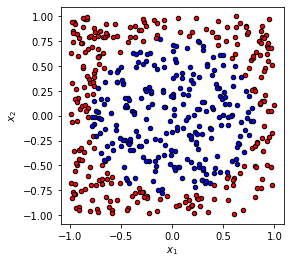

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt


# Set a random seed
np.random.seed(42)


# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

In [32]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    
    y = qml.math.toarray(y)
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [3]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [43]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)
#params = np.random.uniform(size=(num_layers, 3), requires_grad=False)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.397638 | Train accuracy: 0.475000 | Test Accuracy: 0.476000
Epoch:  1 | Loss: 0.206243 | Train accuracy: 0.655000 | Test accuracy: 0.645000
Epoch:  2 | Loss: 0.166793 | Train accuracy: 0.735000 | Test accuracy: 0.757500
Epoch:  3 | Loss: 0.156578 | Train accuracy: 0.800000 | Test accuracy: 0.758000
Epoch:  4 | Loss: 0.152372 | Train accuracy: 0.795000 | Test accuracy: 0.810000
Epoch:  5 | Loss: 0.131218 | Train accuracy: 0.830000 | Test accuracy: 0.814500
Epoch:  6 | Loss: 0.121748 | Train accuracy: 0.875000 | Test accuracy: 0.870500
Epoch:  7 | Loss: 0.115726 | Train accuracy: 0.860000 | Test accuracy: 0.861000
Epoch:  8 | Loss: 0.111747 | Train accuracy: 0.870000 | Test accuracy: 0.850000


KeyboardInterrupt: 

In [4]:
from qiskit_machine_learning.datasets import ad_hoc_data
def qiskitData():
    adhoc_dimension = 2
    train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
        training_size = 20,
        test_size = 5,
        n = adhoc_dimension,
        gap = 0.3,
        plot_data = False, one_hot=False, include_sample_total=True
    )

    X_train = np.hstack((train_features, np.zeros((train_features.shape[0], 1), requires_grad=False)))
    y_train = np.array(train_labels)

    X_test = np.hstack((test_features, np.zeros((test_features.shape[0], 1), requires_grad=False)))
    y_test = np.array(test_labels)
    
    return [[X_train, y_train], [X_test, y_test]]

def pennyData():
    # Generate training and test data
    num_training = 200
    num_test = 2000

    Xdata, y_train = circle(num_training)
    X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

    Xtest, y_test = circle(num_test)
    X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))
    
    return [[X_train, y_train], [X_test, y_test]]

In [5]:

qis = qiskitData()
pen = pennyData()


In [12]:
print("Qiskit")
print(qis[1][1])
print("Penny")
print(pen[1][1])

Qiskit
[0 0 0 0 0 1 1 1 1 1]
Penny
[1 1 1 ... 1 1 0]


In [6]:
def prediction(data):
    X_train = data[0][0]
    y_train = data[0][1]
    
    X_test = data[1][0]
    y_test = data[1][1]
    # Train using Adam optimizer and evaluate the classifier
    num_layers = 3
    learning_rate = 0.6
    epochs = 10
    batch_size = 32

    opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

    # initialize random weights
    params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    
    
    # save predictions with random weights for comparison
    initial_predictions = predicted_test

    loss = cost(params, X_test, y_test, state_labels)

    print(
        "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
            0, loss, accuracy_train, accuracy_test
        )
    )
    for it in range(epochs):
        for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
            params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

        predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
        accuracy_train = accuracy_score(y_train, predicted_train)
        loss = cost(params, X_train, y_train, state_labels)

        predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
        accuracy_test = accuracy_score(y_test, predicted_test)
        res = [it + 1, loss, accuracy_train, accuracy_test]
        print(
            "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
                *res
            )
        )

In [34]:
prediction(pen)

Epoch:  0 | Cost: 0.335856 | Train accuracy: 0.505000 | Test Accuracy: 0.427000
Epoch:  1 | Loss: 0.189876 | Train accuracy: 0.715000 | Test accuracy: 0.703000
Epoch:  2 | Loss: 0.239731 | Train accuracy: 0.655000 | Test accuracy: 0.672500
Epoch:  3 | Loss: 0.204974 | Train accuracy: 0.675000 | Test accuracy: 0.704500
Epoch:  4 | Loss: 0.179007 | Train accuracy: 0.740000 | Test accuracy: 0.733500
Epoch:  5 | Loss: 0.154216 | Train accuracy: 0.790000 | Test accuracy: 0.763500
Epoch:  6 | Loss: 0.128915 | Train accuracy: 0.795000 | Test accuracy: 0.780500
Epoch:  7 | Loss: 0.121703 | Train accuracy: 0.840000 | Test accuracy: 0.795000
Epoch:  8 | Loss: 0.116218 | Train accuracy: 0.845000 | Test accuracy: 0.809000
Epoch:  9 | Loss: 0.110943 | Train accuracy: 0.845000 | Test accuracy: 0.824500
Epoch: 10 | Loss: 0.109037 | Train accuracy: 0.875000 | Test accuracy: 0.830000


In [33]:
prediction(qis)

Epoch:  0 | Cost: 0.441151 | Train accuracy: 0.475000 | Test Accuracy: 0.300000
Epoch:  1 | Loss: 0.323448 | Train accuracy: 0.400000 | Test accuracy: 0.300000
Epoch:  2 | Loss: 0.299307 | Train accuracy: 0.500000 | Test accuracy: 0.400000
Epoch:  3 | Loss: 0.283851 | Train accuracy: 0.625000 | Test accuracy: 0.500000
Epoch:  4 | Loss: 0.271292 | Train accuracy: 0.625000 | Test accuracy: 0.500000
Epoch:  5 | Loss: 0.261641 | Train accuracy: 0.625000 | Test accuracy: 0.500000
Epoch:  6 | Loss: 0.257978 | Train accuracy: 0.675000 | Test accuracy: 0.800000
Epoch:  7 | Loss: 0.259715 | Train accuracy: 0.650000 | Test accuracy: 0.800000
Epoch:  8 | Loss: 0.261314 | Train accuracy: 0.625000 | Test accuracy: 0.800000
Epoch:  9 | Loss: 0.259427 | Train accuracy: 0.600000 | Test accuracy: 0.800000
Epoch: 10 | Loss: 0.255455 | Train accuracy: 0.600000 | Test accuracy: 0.700000


In [28]:
print(qis[0][0])
print(qis[0][1])

[[2.70176968 1.57079633 0.        ]
 [4.52389342 2.76460154 0.        ]
 [3.64424748 4.58672527 0.        ]
 [3.01592895 5.34070751 0.        ]
 [3.51858377 0.43982297 0.        ]
 [0.87964594 6.22035345 0.        ]
 [4.77522083 2.32477856 0.        ]
 [5.84336234 4.52389342 0.        ]
 [0.75398224 5.34070751 0.        ]
 [5.40353936 4.90088454 0.        ]
 [3.14159265 0.87964594 0.        ]
 [3.51858377 4.77522083 0.        ]
 [4.83805269 2.26194671 0.        ]
 [5.15221195 2.19911486 0.        ]
 [4.46106157 2.136283   0.        ]
 [2.07345115 1.94778745 0.        ]
 [0.18849556 5.2150438  0.        ]
 [3.89557489 6.09468975 0.        ]
 [1.44513262 0.43982297 0.        ]
 [3.39292007 0.31415927 0.        ]
 [2.70176968 6.09468975 0.        ]
 [5.15221195 1.19380521 0.        ]
 [4.39822972 4.39822972 0.        ]
 [0.50265482 1.13097336 0.        ]
 [2.136283   3.01592895 0.        ]
 [2.57610598 4.64955713 0.        ]
 [1.31946891 1.00530965 0.        ]
 [4.39822972 0.31415927 0.  

In [29]:
print(pen[0][0])
print(pen[0][1])

[[-5.75739858e-01  9.51153269e-01  0.00000000e+00]
 [ 4.52931108e-01  8.30090252e-01  0.00000000e+00]
 [-3.92277072e-01  4.83733720e-01  0.00000000e+00]
 [ 4.28005417e-01 -4.10620029e-01  0.00000000e+00]
 [ 1.01632651e-01  2.54830223e-01  0.00000000e+00]
 [-3.77363783e-02  6.54357413e-01  0.00000000e+00]
 [ 6.65738084e-01  7.01201097e-01  0.00000000e+00]
 [ 6.06847138e-01 -2.38330456e-02  0.00000000e+00]
 [-2.37123404e-01  6.62752567e-01  0.00000000e+00]
 [-1.95970829e-02 -5.07257203e-01  0.00000000e+00]
 [ 1.46870646e-02 -7.16300356e-01  0.00000000e+00]
 [ 3.83258981e-01 -3.28157437e-01  0.00000000e+00]
 [-4.78682403e-01  9.13017492e-01  0.00000000e+00]
 [ 5.53761992e-01  5.74139005e-01  0.00000000e+00]
 [ 2.47443939e-01  6.78345621e-01  0.00000000e+00]
 [ 5.18324962e-01  1.97547408e-01  0.00000000e+00]
 [ 9.22248804e-01 -6.16810101e-01  0.00000000e+00]
 [ 8.86759438e-01 -1.97123676e-01  0.00000000e+00]
 [ 5.67979668e-02 -7.54521361e-01  0.00000000e+00]
 [ 8.02148778e-02  2.22413504e-

<class 'pennylane.numpy.tensor.tensor'>
<class 'pennylane.numpy.tensor.tensor'>
